In [46]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf


from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [47]:
import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# data_dir = tf.keras.utils.get_file('dates', origin="./train/", untar=True)
data_dir = pathlib.Path("./train/")

In [48]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1156


In [49]:
batch_size = 32
img_height = 180
img_width = 180

In [50]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1156 files belonging to 9 classes.
Using 925 files for training.


In [51]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1156 files belonging to 9 classes.
Using 231 files for validation.


In [52]:
class_names = train_ds.class_names
print(class_names)

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [54]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.95904166


In [55]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

In [58]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 15s 474ms/step - loss: 2.2059 - accuracy: 0.1805 - val_loss: 2.1145 - val_accuracy: 0.2727
Epoch 2/10
29/29 [==============================] - 11s 394ms/step - loss: 1.5077 - accuracy: 0.4627 - val_loss: 1.0698 - val_accuracy: 0.6147
Epoch 3/10
29/29 [==============================] - 11s 363ms/step - loss: 0.8222 - accuracy: 0.7200 - val_loss: 0.6892 - val_accuracy: 0.7922
Epoch 4/10
29/29 [==============================] - 10s 349ms/step - loss: 0.5370 - accuracy: 0.8119 - val_loss: 0.5644 - val_accuracy: 0.8268
Epoch 5/10
29/29 [==============================] - 10s 347ms/step - loss: 0.4197 - accuracy: 0.8508 - val_loss: 0.5637 - val_accuracy: 0.8442
Epoch 6/10
29/29 [==============================] - 10s 347ms/step - loss: 0.3103 - accuracy: 0.8930 - val_loss: 0.4022 - val_accuracy: 0.8831
Epoch 7/10
29/29 [==============================] - 10s 353ms/step - loss: 0.2396 - accuracy: 0.9211 - val_loss: 0.4069 - val_accuracy: 0.8918

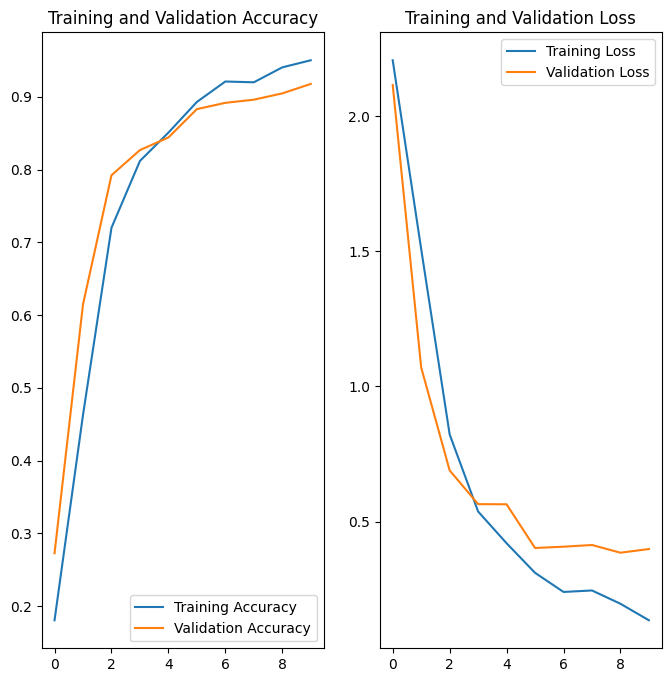

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

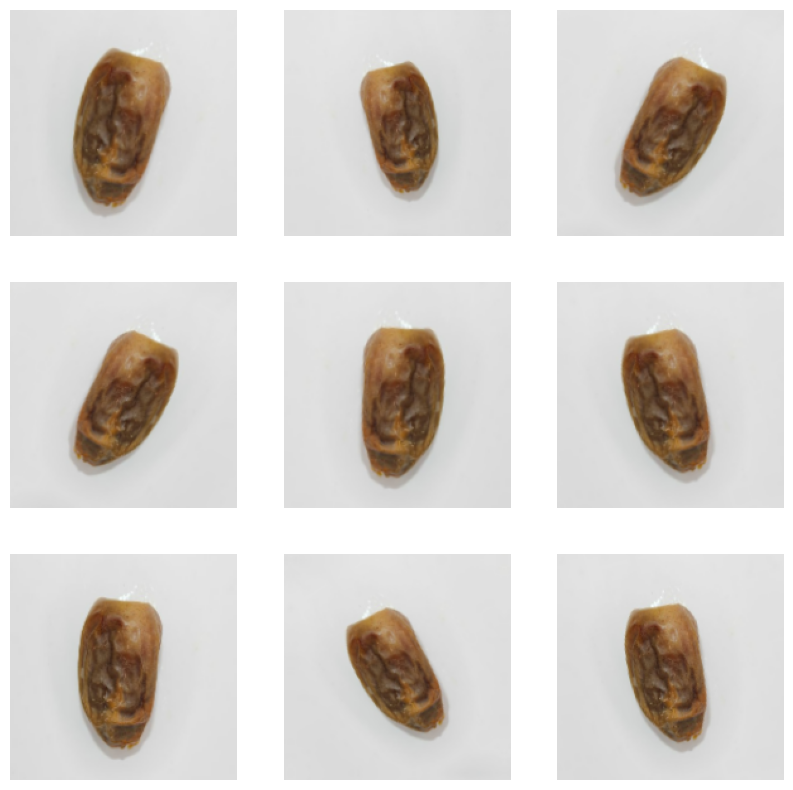

In [61]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [62]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])


In [63]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [64]:
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [65]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
29/29 [==============================] - 16s 422ms/step - loss: 2.3726 - accuracy: 0.1470 - val_loss: 2.0735 - val_accuracy: 0.1905
Epoch 2/15
29/29 [==============================] - 12s 418ms/step - loss: 1.6952 - accuracy: 0.3838 - val_loss: 1.4028 - val_accuracy: 0.5238
Epoch 3/15
29/29 [==============================] - 12s 425ms/step - loss: 1.2082 - accuracy: 0.5665 - val_loss: 1.0022 - val_accuracy: 0.6623
Epoch 4/15
29/29 [==============================] - 12s 420ms/step - loss: 1.1758 - accuracy: 0.5622 - val_loss: 1.0057 - val_accuracy: 0.6667
Epoch 5/15
29/29 [==============================] - 12s 420ms/step - loss: 0.9687 - accuracy: 0.6692 - val_loss: 1.0910 - val_accuracy: 0.6537
Epoch 6/15
29/29 [==============================] - 12s 422ms/step - loss: 0.9343 - accuracy: 0.6822 - val_loss: 0.9764 - val_accuracy: 0.6970
Epoch 7/15
29/29 [==============================] - 12s 416ms/step - loss: 0.7865 - accuracy: 0.7351 - val_loss: 0.7397 - val_accuracy: 0.7879

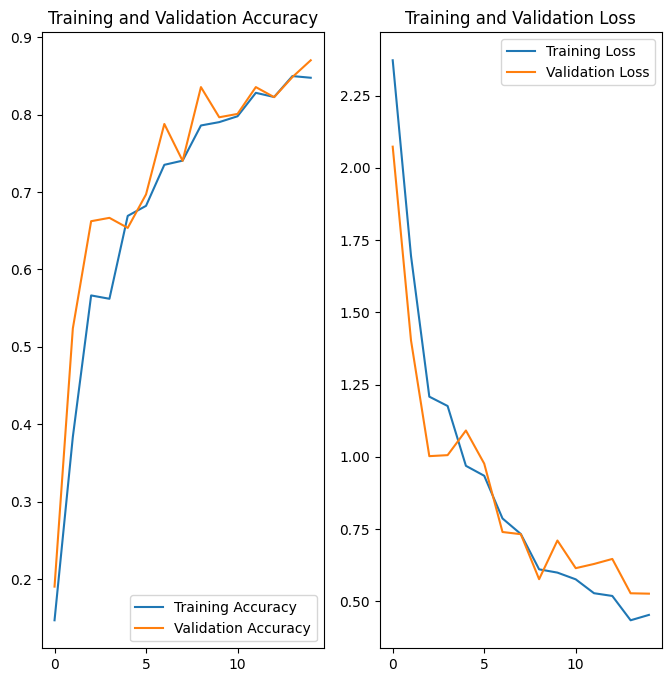

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [78]:
import os
allDir = []
rootdir = './test/'
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        allDir.append(d)

In [84]:
for i in allDir:
    arr = []
    arr = os.listdir(i)
    for j in arr:
        # print(i+j)
        try:
            img = tf.keras.utils.load_img(
                i+"/"+j, target_size=(img_height, img_width)
            )
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0) # Create a batch

            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            print(
                "This image most likely belongs to {} with a {:.2f} percent confidence."
                .format(class_names[np.argmax(score)], 100 * np.max(score))
            )
        except:
            print("Error" + i +"/"+ j)


1/1 [==============================] - 0s 68ms/step
This image most likely belongs to Ajwa with a 98.92 percent confidence.
1/1 [==============================] - 0s 34ms/step
This image most likely belongs to Ajwa with a 99.50 percent confidence.
1/1 [==============================] - 0s 34ms/step
This image most likely belongs to Ajwa with a 98.84 percent confidence.
1/1 [==============================] - 0s 30ms/step
This image most likely belongs to Ajwa with a 99.50 percent confidence.
1/1 [==============================] - 0s 33ms/step
This image most likely belongs to Ajwa with a 99.00 percent confidence.
1/1 [==============================] - 0s 35ms/step
This image most likely belongs to Ajwa with a 99.50 percent confidence.
1/1 [==============================] - 0s 34ms/step
This image most likely belongs to Ajwa with a 99.44 percent confidence.
1/1 [==============================] - 0s 32ms/step
This image most likely belongs to Ajwa with a 99.52 percent confidence.
1/1 [===

In [85]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ahmad\AppData\Local\Temp\tmp_jc1saoh\assets


INFO:tensorflow:Assets written to: C:\Users\ahmad\AppData\Local\Temp\tmp_jc1saoh\assets
